### Traveling Wave Reactor Test

This is intended as a simple notebook in which we learn to use the distributed material functionality in a depletion calculation with OpenMC.

In [1]:
%matplotlib inline
import numpy as np
import openmc
import openmc.deplete
from matplotlib import pyplot

## Materials

In [2]:

# simple clad model.  
clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);
clad.depletable = False

# high-assay, LEU
haleu = openmc.Material(name='haleu');
haleu.add_nuclide("U235",0.1975)
haleu.add_nuclide("U238",0.8025)
haleu.add_nuclide("Pu239",1e-14); # trace amount
haleu.add_element("O",2)
haleu.set_density("g/cc",10.5)
haleu.depletable = True

# depleted U metal pins
dep_u = openmc.Material(name="dep_u");
dep_u.add_nuclide("U234",5e-6);
dep_u.add_nuclide("U235",0.002532);
dep_u.add_nuclide("U238",0.997463);
dep_u.set_density("g/cc",18.95);
dep_u.depletable = True
                        
# Sodium coolant
sodium = openmc.Material(name='sodium');
sodium.add_element("Na",1);
sodium.set_density("g/cc",0.971)
sodium.depletable = False

## Geometry

#### core and pin lattice parameters

In [3]:
h_fuel = 100. # cm
h_core = 150. # cm
r_core = 60. # cm

P_D = 1.2 # pitch/diameter ratio of pins in a lattice
#N_assy = 301; # number of pins per dimension in the assembly (make this odd)
N_assy = 51;
N_seed = 11;

#N_seed = 95; # number of pins per dimension in the seed part of the assembly (make this odd)

r_fo = 0.4096 # cm, fuel outer radius for clad UO2 driver pins
r_pin = 0.4751 # cm, pin outer radius for all pins including unclad dep_u metallic pins
t_clad = r_pin-r_fo;

pin_pitch = r_pin*2.*P_D;
a_pitch = N_assy*pin_pitch;

c_boundary = 1.1*a_pitch;

#### Surfaces

In [4]:
oxide_c = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel,r_fo);

pin_c = openmc.model.RightCircularCylinder([0., 0., -(h_fuel+2.*t_clad)/2.],
                                           h_fuel+2.*t_clad,r_pin)

assy_bdy = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -(h_fuel+2.*t_clad)/2.,(h_fuel+2.*t_clad)/2.)

core_bdy = openmc.model.RightCircularCylinder((0,0,-h_fuel),2*h_fuel,3.*a_pitch,
                                               boundary_type='vacuum')

#### Cells

In [5]:
haleu_cell = openmc.Cell()
haleu_cell.region = -oxide_c
haleu_cell.fill = haleu

clad_cell = openmc.Cell()
clad_cell.region = +oxide_c & -pin_c
clad_cell.fill = clad

driver_cool_cell = openmc.Cell()
driver_cool_cell.region = +pin_c
driver_cool_cell.fill = sodium

depu_cell = openmc.Cell()
depu_cell.region = -pin_c
depu_cell.fill = dep_u

blanket_cool_cell = openmc.Cell()
blanket_cool_cell.region = +pin_c
blanket_cool_cell.fill = sodium

all_sodium_cell = openmc.Cell()
all_sodium_cell.fill = sodium



#### Universes

Define the universes that will be needed in the core lattice

In [6]:
spu = openmc.Universe(); # seed pin universe
spu.add_cells([haleu_cell,clad_cell,driver_cool_cell])

bpu = openmc.Universe(); # blanket pin universe
bpu.add_cells([depu_cell,blanket_cool_cell])

all_sodium = openmc.Universe()
all_sodium.add_cell(all_sodium_cell);

In [7]:
lattice = openmc.RectLattice();
lattice.dimension = [N_assy,N_assy];
lattice.lower_left = [-N_assy*pin_pitch/2.,-N_assy*pin_pitch/2.]
lattice.pitch = [pin_pitch,pin_pitch];

# start with everything a blanket pin universe
lattice.universes = [[ bpu for i in range(N_assy)] for j in range(N_assy)];

# change the lattice universes in the seed region to spu
u_ind_min = np.int32(np.floor(N_assy/2)-np.floor(N_seed/2))
u_ind_max = np.int32(u_ind_min + N_seed)

for i in range(u_ind_min,u_ind_max):
    for j in range(u_ind_min,u_ind_max):
        lattice.universes[i,j] = spu

lattice.outer = all_sodium

core_cell = openmc.Cell()
core_cell.fill = lattice
core_cell.region = -core_bdy

root = openmc.Universe()
root.add_cells([core_cell])

geometry = openmc.Geometry();
geometry.root_universe = root;
geometry.export_to_xml();

# Calculate volume of depletable materials
N_sp = N_seed*N_seed;
V_sp = h_fuel*(np.pi)*r_fo**2;
haleu.volume = N_sp*V_sp;

N_bp = N_assy**2 - N_sp
V_bp = h_fuel*(np.pi)*r_pin**2; # blanket pins have no cladding
dep_u.volume = N_bp*V_bp;

geometry.determine_paths();


materials = openmc.Materials();
materials+=[clad,haleu,dep_u,sodium];
materials.export_to_xml();


In [8]:
#plot = openmc.Plot.from_geometry(g)
#%plot.color_by = 'material'
#plot.colors = {
#    clad: 'grey',
#    haleu: 'yellow',
#    dep_u: 'green',
#    sodium: 'blue'
#}
#plot.to_ipython_image()


#### Plot the Universe

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

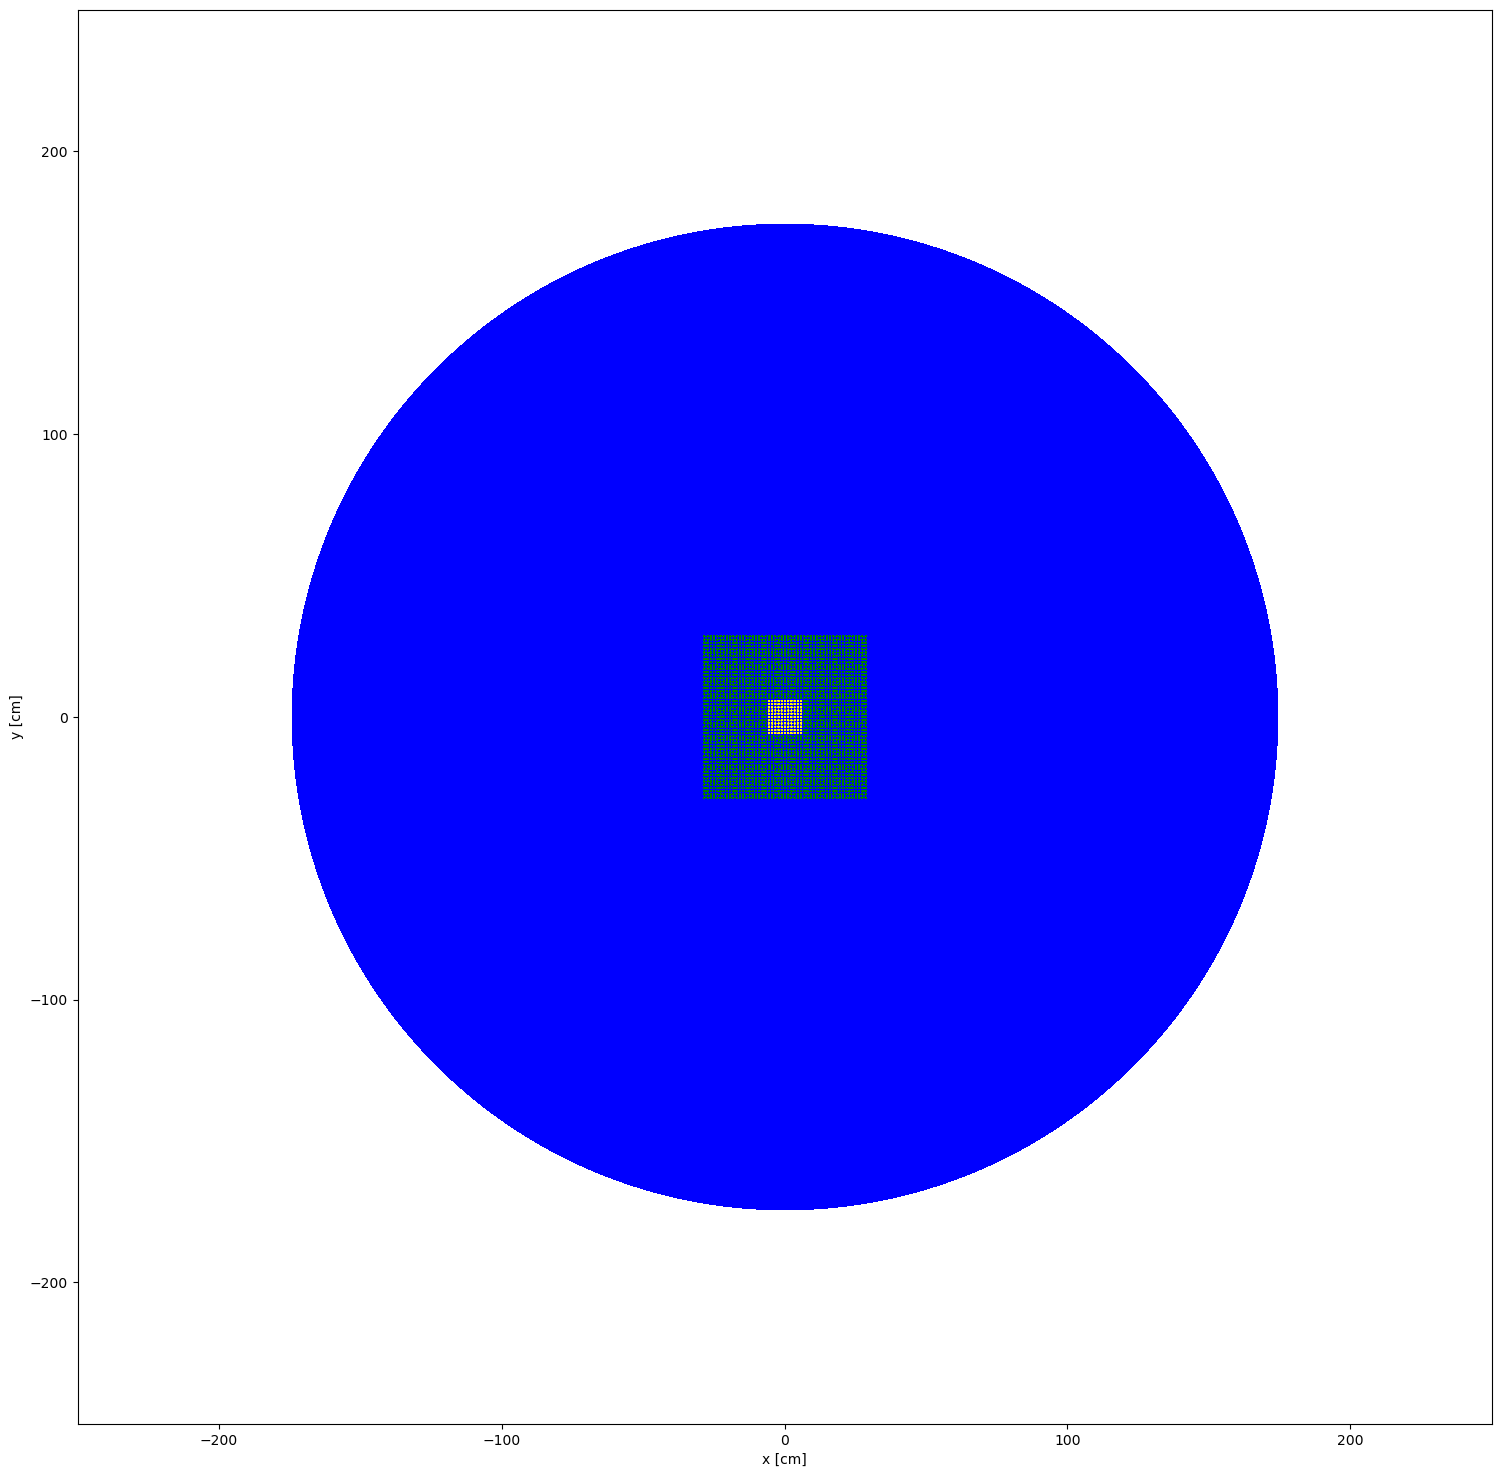

In [9]:
colors = {
    clad: 'grey',
    haleu: 'yellow',
    dep_u: 'green',
    sodium: 'blue'
}


plot_args = {
    'width':(500,500),
    'basis':'xy',
    'color_by':'material',
    'pixels': 2000000,
    'colors':colors
}

root.plot(**plot_args)

### Add settings for initial k_eff calculation

In [10]:
bounds = [-a_pitch/2, -a_pitch/2, -h_fuel/2, a_pitch/2, a_pitch/2, h_fuel/2];

uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                                only_fissionable=True);
settings = openmc.Settings()
settings.batches = 150;
settings.inactive = 50;
settings.particles = 10000;
settings.source = openmc.IndependentSource(space=uniform_dist);
settings.export_to_xml()



### Add some tallies

The main effect that I want to see is the spatial distribution of fission events within the core.  I might also want to filter for fissions with various isotopes.  Since this is a fast spectrum reactor, there will be more isotopes undergoing fission than usual.

In [11]:
fission_t = openmc.Tally(name='fission tally');
fission_t.scores = ['fission'];

# create a RegularMesh object
mesh = openmc.RegularMesh()
mesh.dimension = [150, 150, 3];# number of divisions in the x-, y-, and z-direction
mesh.lower_left = [-a_pitch/2., -a_pitch/2.,-h_fuel/2.]
mesh.upper_right = [a_pitch/2.,a_pitch/2.,h_fuel/2.]

# use the RegularMesh to create a MeshFilter object
mesh_f = openmc.MeshFilter(mesh)

# apply the MeshFilter to the fission tally
fission_t.filters=[mesh_f]

# create a tallies object and write to xml
tallies = openmc.Tallies([fission_t])
tallies.export_to_xml()

In [12]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [13]:
# take a look at the tallied results and learn how to read and visualize the data
sp_file_name = f'statepoint.{settings.batches}.h5'

sp = openmc.StatePoint(sp_file_name)

fission_t = sp.get_tally(name='fission tally');
#fission_df = fission_t.get_pandas_dataframe()
#fission_vals = fission_df['mean'].to_numpy()

In [14]:
fission_mean = fission_t.mean.reshape(mesh.dimension)
mesh.write_data_to_vtk(filename="fission.vtk",datasets={"fission":fission_mean})

<vtkmodules.vtkCommonDataModel.vtkStructuredGrid(0x558d8d16b230) at 0x14fffe89a4c0>

In [15]:
sp.close()

In [16]:
model = openmc.model.Model(geometry,materials,settings)
model.differentiate_depletable_mats(diff_volume_method = 'divide equally')
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_sfr.xml",
                                          diff_burnable_mats=True) 

#operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_sfr.xml")

power_density = 35 # MW/kg
days = 3600*24
#time_steps = [0.1*days,0.2*days,0.3*days,0.5*days,1*days,10*days,10*days,30*days,30*days]
time_steps = [180*days, 180*days, 180*days, 180*days]
cemc = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density,
                                     timestep_units='s')
              


In [17]:
cemc.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5


 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Nb95 from /home/sblair/OMC_DATA/endfb71_hdf5/Nb95.h5
 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb7

          1200K
          2500K


 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/O

          1200K
          2500K


 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5


          1200K
          2500K


 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

          1200K


 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.28617
        2/1    0.30440
        3/1    0.31559
        4/1    0.32303
        5/1    0.32798
        6/1    0.33158
        7/1    0.33212
        8/1    0.32805
        9/1    0.33470
       10/1    0.33488
       11/1    0.33725
       12/1    0.33401
       13/1    0.33328
       14/1    0.33013
       15/1    0.33327
       16/1    0.34064
       17/1    0.32737
       18/1    0.33666
       19/1    0.34044
       20/1    0.33365
       21/1    0.33891
       22/1    0.32306
       23/1    0.32967
       24/1    0.33171
       25/1    0.33323
       26/1    0.33563
       27/1    0.32694
       28/1    0.32974
       29/1    0.33787
       30/1    0.33321
       31/1    0.33395
       32/1    0.33549
       33/1    0.33656
       34/1    0.33479
       35/1    0.34

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.39305
        2/1    0.41384
        3/1    0.42507
        4/1    0.43977
        5/1    0.44368
        6/1    0.43517
        7/1    0.44378
        8/1    0.44519
        9/1    0.44380
       10/1    0.44318
       11/1    0.44348
       12/1    0.43747
       13/1    0.45022
       14/1    0.45065
       15/1    0.44222
       16/1    0.44655
       17/1    0.44558
       18/1    0.44692
       19/1    0.44904
       20/1    0.44856
       21/1    0.44913
       22/1    0.43988
       23/1    0.44721
       24/1    0.44186
       25/1    0.44061
       26/1    0.44374
       27/1    0.44080
       28/1    0.44532
       29/1    0.44455
       30/1    0.44593
       31/1    0.44717
       32/1    0.44621
       33/1    0.44215
       34/1    0.44665
       35/1    0.45

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.42813
        2/1    0.45370
        3/1    0.45746
        4/1    0.47181
        5/1    0.47820
        6/1    0.48048
        7/1    0.48085
        8/1    0.48830
        9/1    0.48723
       10/1    0.48152
       11/1    0.48643
       12/1    0.48652
       13/1    0.49090
       14/1    0.48670
       15/1    0.47962
       16/1    0.48670
       17/1    0.48273
       18/1    0.48587
       19/1    0.48457
       20/1    0.48088
       21/1    0.48584
       22/1    0.48157
       23/1    0.48211
       24/1    0.48833
       25/1    0.49286
       26/1    0.48469
       27/1    0.48354
       28/1    0.48428
       29/1    0.46710
       30/1    0.49124
       31/1    0.47735
       32/1    0.48085
       33/1    0.47747
       34/1    0.48485
       35/1    0.48

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.48094
        2/1    0.50531
        3/1    0.52505
        4/1    0.52800
        5/1    0.53205
        6/1    0.54031
        7/1    0.54082
        8/1    0.53391
        9/1    0.52747
       10/1    0.52925
       11/1    0.52648
       12/1    0.53566
       13/1    0.52428
       14/1    0.54035
       15/1    0.53777
       16/1    0.52941
       17/1    0.53708
       18/1    0.53417
       19/1    0.53105
       20/1    0.53388
       21/1    0.53750
       22/1    0.53114
       23/1    0.53025
       24/1    0.53909
       25/1    0.53220
       26/1    0.53031
       27/1    0.53395
       28/1    0.52352
       29/1    0.53672
       30/1    0.52836
       31/1    0.53559
       32/1    0.53503
       33/1    0.54105
       34/1    0.53539
       35/1    0.53

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.51172
        2/1    0.53930
        3/1    0.57265
        4/1    0.55790
        5/1    0.56290
        6/1    0.56993
        7/1    0.56588
        8/1    0.55574
        9/1    0.57092
       10/1    0.56821
       11/1    0.56797
       12/1    0.56566
       13/1    0.57034
       14/1    0.57417
       15/1    0.57077
       16/1    0.56764
       17/1    0.56229
       18/1    0.57182
       19/1    0.56852
       20/1    0.57102
       21/1    0.55672
       22/1    0.56974
       23/1    0.56769
       24/1    0.57760
       25/1    0.56377
       26/1    0.56878
       27/1    0.56755
       28/1    0.56205
       29/1    0.57045
       30/1    0.57255
       31/1    0.56804
       32/1    0.56701
       33/1    0.57377
       34/1    0.57119
       35/1    0.56

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.53732
        2/1    0.57706
        3/1    0.58553
        4/1    0.58717
        5/1    0.59380
        6/1    0.60542
        7/1    0.60311
        8/1    0.60481
        9/1    0.61039
       10/1    0.61164
       11/1    0.59672
       12/1    0.58985
       13/1    0.58738
       14/1    0.59513
       15/1    0.58732
       16/1    0.59584
       17/1    0.60940
       18/1    0.60464
       19/1    0.60165
       20/1    0.60075
       21/1    0.60083
       22/1    0.59322
       23/1    0.59375
       24/1    0.60754
       25/1    0.60342
       26/1    0.60807
       27/1    0.59880
       28/1    0.59328
       29/1    0.59982
       30/1    0.60836
       31/1    0.59882
       32/1    0.59966
       33/1    0.59795
       34/1    0.59882
       35/1    0.59

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.56341
        2/1    0.59423
        3/1    0.60847
        4/1    0.61430
        5/1    0.62480
        6/1    0.63665
        7/1    0.62126
        8/1    0.62887
        9/1    0.63242
       10/1    0.61097
       11/1    0.62710
       12/1    0.62468
       13/1    0.62346
       14/1    0.62693
       15/1    0.62148
       16/1    0.62182
       17/1    0.62636
       18/1    0.63032
       19/1    0.63015
       20/1    0.62199
       21/1    0.63205
       22/1    0.62839
       23/1    0.61485
       24/1    0.62622
       25/1    0.61936
       26/1    0.63209
       27/1    0.62446
       28/1    0.63375
       29/1    0.62385
       30/1    0.63312
       31/1    0.63314
       32/1    0.63100
       33/1    0.62886
       34/1    0.62271
       35/1    0.63

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59132
        2/1    0.62023
        3/1    0.62627
        4/1    0.63812
        5/1    0.64361
        6/1    0.64614
        7/1    0.65617
        8/1    0.64134
        9/1    0.65415
       10/1    0.64657
       11/1    0.65140
       12/1    0.65069
       13/1    0.64058
       14/1    0.65754
       15/1    0.65283
       16/1    0.65480
       17/1    0.64321
       18/1    0.64740
       19/1    0.65616
       20/1    0.65131
       21/1    0.64710
       22/1    0.65645
       23/1    0.63443
       24/1    0.64904
       25/1    0.65381
       26/1    0.64384
       27/1    0.64001
       28/1    0.64181
       29/1    0.64235
       30/1    0.65226
       31/1    0.64883
       32/1    0.65669
       33/1    0.63171
       34/1    0.64833
       35/1    0.64

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59824
        2/1    0.62410
        3/1    0.63904
        4/1    0.66852
        5/1    0.66272
        6/1    0.67100
        7/1    0.66712
        8/1    0.66437
        9/1    0.67065
       10/1    0.66461
       11/1    0.67337
       12/1    0.66049
       13/1    0.65580
       14/1    0.66754
       15/1    0.65543
       16/1    0.66875
       17/1    0.65958
       18/1    0.66277
       19/1    0.65798
       20/1    0.67122
       21/1    0.66475
       22/1    0.66746
       23/1    0.66775
       24/1    0.66282
       25/1    0.67413
       26/1    0.67330
       27/1    0.66353
       28/1    0.65743
       29/1    0.66171
       30/1    0.67075
       31/1    0.67127
       32/1    0.66966
       33/1    0.66988
       34/1    0.66389
       35/1    0.66

### Extract Tally Data
We will iterate through the statepoint files and get the fission tally results and write everything to a series of VTK files

In [19]:
numTS = len(time_steps)

for ts in range(numTS+1):
    sp_fn = f'openmc_simulation_n{ts}.h5'
    sp = openmc.StatePoint(sp_fn)
    fiss_t = sp.get_tally(name='fission tally')
    fiss_m = fiss_t.mean.reshape(mesh.dimension)
    vtk_fn = f'fission_dep{ts}.vtk'
    mesh.write_data_to_vtk(filename=vtk_fn,datasets={"fission":fiss_m})
    sp.close()


Now the fission mesh tally is written to a VTK file that can be visualized with a tool like ParaView.  It *appears* to show hints of the expected time/space variation in fission indicating that individual pins are being depleted separately.